In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Veri okuma ve işleme fonksiyonları
def getdata(path):
    data = pd.read_csv(path)
    data['PROFILEDATE'] = pd.to_datetime(data['PROFILEDATE'].astype('str'), format ='%Y%m%d%H%M%S')
    return data[['POINTSERNO', 'PROFILEDATE', 'IMPORTNETTING']].reset_index(drop=True)

def getdata_e(path):
    data = pd.read_csv(path)
    data['PROFILEDATE'] = pd.to_datetime(data['PROFILEDATE'].astype('str'), format ='%Y%m%d%H%M%S')
    return data[['POINTSERNO', 'PROFILEDATE', 'IMPORTESTIMATED']].reset_index(drop=True)

# Veriyi okuma
tic_ag = getdata(r'C:\Users\ASUS\Ticarethane_AG\faz2_tic_ag.csv')
tic_ag_e = getdata_e(r'C:\Users\ASUS\Ticarethane_AG\faz2_tic_ag.csv')

In [3]:
def create_pivot_table(dataframe):
    pivot_table = dataframe.pivot_table(
        values='IMPORTNETTING',  
        index='POINTSERNO',     
        columns='PROFILEDATE',    
        aggfunc='sum',
        fill_value=np.nan           
    )

    rows_to_keep = pivot_table.sum(axis=1) != 0

    # Apply the filter to the pivot_table to drop rows with a sum of 0
    filtered_table = pivot_table[rows_to_keep]
    filtered_table.columns = pd.to_datetime(filtered_table.columns)
    selected_dates = filtered_table.loc[:, '2023-12-01':'2024-01-31']
    selected_dates = selected_dates.dropna(how='any')
        
    if (selected_dates.isna().sum().sum()) == 0:
        print('There is no nan values and we can continue to the next step')
    else:
        print('There are nan values in the dataset, please check the data')
    return(selected_dates)
r_ = create_pivot_table(tic_ag)

melt_df = r_.reset_index().melt(id_vars='POINTSERNO', var_name='Date', value_name='Value')
melt_df.sort_values('Date', inplace=True)

df_pivoted = melt_df.pivot(index='Date', columns='POINTSERNO', values='Value')

checkpoint1 = df_pivoted.isna().sum().sum()

assert checkpoint1 == 0 , f'df_pivot has NaN'

df_pivoted = df_pivoted.loc[:, df_pivoted.sum(axis=0) != 0]

unique_columns = df_pivoted.apply(lambda x: x.nunique() == 1)

columns_to_drop = unique_columns[unique_columns].index.tolist()

# Drop these columns from the DataFrame
df_main = df_pivoted.drop(columns=columns_to_drop)
df_main

There is no nan values and we can continue to the next step


POINTSERNO,5318,5436,5441,5586,5682,5684,5685,5968,6004,6027,...,277840,299331,319240,320016,320345,320437,320650,320876,342972,343618
Date,,,,,,,,,,,,,,,,,,,,,
2023-12-01 00:00:00,0.1112,0.04044,0.0886,0.09904,0.24108,0.01920,0.2204,0.01350,0.00032,0.12396,...,0.012105,0.011486,0.008736,0.02875,0.003732,0.000024,0.003683,0.007020,0.00453,0.05910
2023-12-01 01:00:00,0.0808,0.03936,0.0908,0.10416,0.23916,0.01864,0.2132,0.01400,0.00032,0.12282,...,0.011076,0.007214,0.008356,0.00030,0.004967,0.000024,0.003704,0.006720,0.00573,0.05035
2023-12-01 02:00:00,0.0720,0.04104,0.0910,0.09568,0.24156,0.01976,0.2296,0.01400,0.00036,0.12492,...,0.010524,0.007160,0.007906,0.04775,0.004848,0.000025,0.003568,0.008460,0.00429,0.05005
2023-12-01 03:00:00,0.0688,0.04140,0.1044,0.10768,0.24300,0.01952,0.2168,0.01375,0.00044,0.12336,...,0.012390,0.007184,0.008642,0.00025,0.004978,0.000025,0.006729,0.009420,0.00576,0.05820
2023-12-01 04:00:00,0.0728,0.03888,0.1070,0.09744,0.24528,0.01680,0.2162,0.01400,0.00368,0.12390,...,0.010244,0.006937,0.008450,0.03240,0.003667,0.000024,0.012086,0.008040,0.00429,0.05450
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-01-31 19:00:00,0.1120,0.04368,0.1006,0.09040,0.24648,0.03968,0.2274,0.05550,0.00048,0.12402,...,0.017893,0.023648,0.021452,0.03105,0.010966,0.003204,0.005149,0.007318,0.00276,0.03160
2024-01-31 20:00:00,0.1024,0.04380,0.0998,0.08480,0.24768,0.03192,0.2298,0.04275,0.00200,0.12606,...,0.016168,0.024883,0.018387,0.02765,0.008624,0.003153,0.005103,0.007198,0.00234,0.07175
2024-01-31 21:00:00,0.0952,0.03624,0.0992,0.09408,0.24888,0.02464,0.2316,0.03725,0.00216,0.12840,...,0.017596,0.024865,0.011260,0.02335,0.008147,0.003189,0.004889,0.008098,0.00213,0.07215


In [4]:
def create_pivot_table(dataframe):
    pivot_table = dataframe.pivot_table(
        values='IMPORTNETTING',  
        index='POINTSERNO',     
        columns='PROFILEDATE',    
        aggfunc='sum',
        fill_value=np.nan           
    )

    rows_to_keep = pivot_table.sum(axis=1) != 0

    # Apply the filter to the pivot_table to drop rows with a sum of 0
    filtered_table = pivot_table[rows_to_keep]
    filtered_table.columns = pd.to_datetime(filtered_table.columns)
    selected_dates = filtered_table.loc[:, '2024-02-01':'2024-02-29']
    selected_dates = selected_dates.dropna(how='any')
        
    if (selected_dates.isna().sum().sum()) == 0:
        print('There is no nan values and we can continue to the next step')
    else:
        print('There are nan values in the dataset, please check the data')
    return(selected_dates)
r_ = create_pivot_table(tic_ag)

melt_df = r_.reset_index().melt(id_vars='POINTSERNO', var_name='Date', value_name='Value')
melt_df.sort_values('Date', inplace=True)

df_pivoted = melt_df.pivot(index='Date', columns='POINTSERNO', values='Value')

checkpoint1 = df_pivoted.isna().sum().sum()

assert checkpoint1 == 0 , f'df_pivot has NaN'

df_pivoted = df_pivoted.loc[:, df_pivoted.sum(axis=0) != 0]

unique_columns = df_pivoted.apply(lambda x: x.nunique() == 1)

columns_to_drop = unique_columns[unique_columns].index.tolist()

# Drop these columns from the DataFrame
df_feb = df_pivoted.drop(columns=columns_to_drop)
df_feb

There is no nan values and we can continue to the next step


POINTSERNO,5318,5436,5441,5586,5682,5684,5685,5968,6004,6027,...,319240,320016,320345,320437,320650,320876,342972,343618,344094,344099
Date,,,,,,,,,,,,,,,,,,,,,
2024-02-01 00:00:00,0.0928,0.02892,0.0986,0.08240,0.25080,0.02216,0.2158,0.02550,0.00224,0.11952,...,0.008695,0.02095,0.003937,0.000019,0.004888,0.00690,0.00390,0.03410,0.023750,0.047467
2024-02-01 01:00:00,0.0936,0.02928,0.1014,0.09296,0.24828,0.02400,0.2156,0.02750,0.00212,0.11274,...,0.008754,0.00030,0.004126,0.000019,0.004905,0.00648,0.00378,0.03265,0.023765,0.049206
2024-02-01 02:00:00,0.0920,0.02916,0.1048,0.08448,0.24792,0.02376,0.2098,0.02725,0.00204,0.10992,...,0.008658,0.00030,0.004709,0.000020,0.004787,0.00720,0.00372,0.03205,0.023819,0.049926
2024-02-01 03:00:00,0.0936,0.02940,0.1244,0.08912,0.24804,0.02264,0.2218,0.02700,0.00176,0.11256,...,0.009017,0.03770,0.003814,0.000019,0.006883,0.00780,0.00372,0.03165,0.023866,0.048037
2024-02-01 04:00:00,0.0944,0.02664,0.1172,0.08480,0.25296,0.01928,0.2292,0.02725,0.00240,0.10908,...,0.009208,0.03750,0.003960,0.000020,0.013389,0.00624,0.00372,0.03505,0.023865,0.048307
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-02-29 19:00:00,0.1088,0.05484,0.1030,0.07824,0.25308,0.03936,0.2050,0.02200,0.00044,0.12336,...,0.019585,0.02590,0.011674,0.004067,0.004714,0.01026,0.00195,0.04730,0.042454,0.025158
2024-02-29 20:00:00,0.1016,0.07572,0.0968,0.07104,0.25272,0.03448,0.2070,0.01500,0.00048,0.12252,...,0.020313,0.02785,0.009922,0.003164,0.004442,0.00948,0.00210,0.04390,0.042286,0.025638
2024-02-29 21:00:00,0.1024,0.05532,0.0878,0.08176,0.25644,0.02760,0.2040,0.01275,0.00040,0.11892,...,0.012742,0.02720,0.010300,0.003161,0.004413,0.01038,0.00201,0.05995,0.042280,0.026537


In [5]:
common_columns = df_main.columns.intersection(df_feb.columns)
common_columns
df_main = df_main[common_columns]

In [6]:

#                           NORMALISING FUNCTION--> NORMALIZES VALUES /   DF --> ARRAY
def normalise_data(rawdata, normalise=2):
    
    data = np.zeros(rawdata.shape)

    n, m = rawdata.shape
    scale = np.ones(m)
    if normalise == 0: # do not normalise
        data = rawdata

    if normalise == 1: # same normalisation for all timeseries
        data = rawdata / np.max(rawdata)

    if normalise == 2: # normalise each timeseries alone. This is the default mode
        for i in range(m):
            scale[i] = np.max(np.abs(rawdata.iloc[:, i]))
            data[:, i] = rawdata.iloc[:, i] / scale[i]
    return data

In [7]:

def get_training_sequences(y, n_lookback):
 
   
 
    X = np.zeros((y.shape[0], n_lookback, y.shape[1]))
    Y = np.zeros((y.shape[0], y.shape[1]))
 
    for i in range(n_lookback, y.shape[0]):
 
        X[i, :, :] = y[i - n_lookback: i, :]
        Y[i, :] = y[i, :]
 
    X = X[n_lookback:, :, :]
    Y = Y[n_lookback:, :]
 
    return X, Y


In [8]:
def reverse_normalisation(normalised_data, scale_factors, normalise=2):
    if normalised_data.ndim == 1:
        # Eğer normalised_data 1D ise, buna göre işlemleri yap
        n = normalised_data.shape[0]
        reversed_data = np.zeros_like(normalised_data)
        
        if normalise == 0:  # No need
            reversed_data = normalised_data
        
        elif normalise == 1:  # CONVERTS EACH TIME SERIES(BASED ON COLUMNS)
            reversed_data = normalised_data * np.max(scale_factors)  # * MAX VALUE--According to normalise_data function
        
        elif normalise == 2:  # CONVERTS EACH TIME SERIES(BASED ON COLUMNS)
            reversed_data = normalised_data * scale_factors[0]
        
    else:
        # Eğer normalised_data 2D ise, mevcut işlemleri kullan
        n, m = normalised_data.shape
        reversed_data = np.zeros_like(normalised_data)
        
        if normalise == 0:  # No need
            reversed_data = normalised_data
        
        elif normalise == 1:  # CONVERTS EACH TIME SERIES(BASED ON COLUMNS)
            reversed_data = normalised_data * np.max(scale_factors)  # * MAX VALUE--According to normalise_data function
        
        elif normalise == 2:  # CONVERTS EACH TIME SERIES(BASED ON COLUMNS)
            for i in range(m):
                reversed_data[:, i] = normalised_data[:, i] * scale_factors[i]
    
    return reversed_data  # ACTUAL VALUES

In [9]:
def create_pivot_table_for_compare(dataframe,date):
    pivot_table = dataframe.pivot_table(
        values='IMPORTNETTING',  
        index='POINTSERNO',     
        columns='PROFILEDATE',    
        aggfunc='sum',
        fill_value=np.nan           
    )

    rows_to_keep = pivot_table.sum(axis=1) != 0

    # Apply the filter to the pivot_table to drop rows with a sum of 0
    filtered_table = pivot_table[rows_to_keep]
    filtered_table.columns = pd.to_datetime(filtered_table.columns)
    selected_dates = filtered_table.loc[:, date:date]
    selected_dates = selected_dates.dropna(how='any')
        
    
    return(selected_dates)

def comparedf (dataframe,date):
    r_ = create_pivot_table_for_compare(dataframe,date)

    melt_df = r_.reset_index().melt(id_vars='POINTSERNO', var_name='Date', value_name='Value')
    melt_df.sort_values('Date', inplace=True)

    df_pivoted = melt_df.pivot(index='Date', columns='POINTSERNO', values='Value')

    checkpoint1 = df_pivoted.isna().sum().sum()

    assert checkpoint1 == 0 , f'df_pivot has NaN'

    #df_pivoted = df_pivoted.loc[:, df_pivoted.sum(axis=0) != 0]

    # unique_columns = df_pivoted.apply(lambda x: x.nunique() == 1)

    # columns_to_drop = unique_columns[unique_columns].index.tolist()

    # # Drop these columns from the DataFrame
    # df_act= df_pivoted.drop(columns=columns_to_drop)# df_main benim ana datasetim.. Aralık ve Ocağı verip şubatı tahmin ettireceğim
    df_act = df_pivoted
    return df_act

In [10]:
date_try_exe = []

In [11]:
from tqdm import tqdm

In [12]:
# Ana döngü
allPred = pd.DataFrame()
for column in tqdm(df_main.columns):
    workFrame = df_main[[column]]
    
    
    column_pred = pd.DataFrame()
    
    for i in range(29):
        data = normalise_data(workFrame)
        X_train, Y_train = get_training_sequences(data, 168)
        X_train = X_train.reshape(X_train.shape[0], -1)
        
        # NaN veya sonsuz değerlerin kontrolü ve temizlenmesi
        Y_train = np.nan_to_num(Y_train, nan=np.nanmean(Y_train), posinf=np.nanmean(Y_train), neginf=np.nanmean(Y_train))
        
        model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=6000, learning_rate=0.001)
        model.fit(X_train, Y_train)
        
        test = X_train[-24:]
        predict = model.predict(test)
        
        #Reverse it!
        predict = reverse_normalisation(predict, scale_factors=np.max(workFrame.values, axis=0))
        
        new_index = df_main.index[-24:] + pd.DateOffset(days=1)
        predict_df = pd.DataFrame(predict, index=new_index, columns=[column])
        
        if i == 0:
            column_pred = predict_df.copy()
        else:
            column_pred = pd.concat([column_pred, predict_df], ignore_index=False)
        
        compare_date = predict_df.index[-1].strftime('%Y-%m-%d')
        
        
        try:
            actual_data_for_day = comparedf(tic_ag, compare_date)[[column]]
            workFrame = pd.concat([workFrame, actual_data_for_day], ignore_index=False)
        
        except KeyError as e:
            print(f"KeyError: {e} - Column: {column} on Date: {compare_date}")
            actual_data_for_day = predict_df.copy()
            workFrame = pd.concat([workFrame, actual_data_for_day], ignore_index=False)
        
        except Exception as e:
            print(f"An error occurred: {e} - Column: {column} on Date: {compare_date}")
            actual_data_for_day = predict_df.copy()
            workFrame = pd.concat([workFrame, actual_data_for_day], ignore_index=False)
    

    # Reset index of column_pred to avoid index issues when concatenating
    column_pred.reset_index(drop=True, inplace=True)
    allPred = pd.concat([allPred, column_pred], axis=1, ignore_index=False)
    
    

100%|██████████| 218/218 [1:10:17<00:00, 19.34s/it]


In [13]:
allPred

,5318,5436,5441,5586,5682,5684,5685,5968,6004,6027,...,277840,299331,319240,320016,320345,320437,320650,320876,342972,343618
0,0.165647,0.079675,0.141942,0.108534,0.240938,0.028887,0.227657,0.102436,0.003216,0.131293,...,0.016365,0.015193,0.016676,0.033479,0.009052,0.004000,0.008738,0.021392,0.013113,0.038148
1,0.165647,0.079675,0.141942,0.108532,0.240938,0.028893,0.227660,0.102436,0.003216,0.131293,...,0.016371,0.015092,0.016676,0.033641,0.009052,0.004000,0.008738,0.021392,0.013113,0.038212
2,0.165647,0.079675,0.142030,0.108534,0.240938,0.028908,0.227590,0.102436,0.003216,0.131293,...,0.016371,0.015029,0.016676,0.033966,0.009052,0.004000,0.008738,0.021392,0.013113,0.038120
3,0.165647,0.079675,0.142030,0.108589,0.240938,0.028887,0.227501,0.102436,0.003216,0.131293,...,0.016365,0.015029,0.016676,0.033738,0.009052,0.004000,0.008779,0.021392,0.013113,0.038120
4,0.165647,0.079675,0.142391,0.108534,0.240982,0.028887,0.227501,0.102436,0.003207,0.131214,...,0.016371,0.015029,0.016676,0.033586,0.009052,0.004000,0.008829,0.021392,0.013113,0.037973
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
691,0.180001,0.068447,0.151249,0.111594,0.254656,0.030777,0.228991,0.119391,0.003531,0.130575,...,0.015923,0.015470,0.016781,0.033287,0.009119,0.004049,0.009079,0.019824,0.015058,0.039572
692,0.180001,0.068532,0.151207,0.111524,0.254656,0.030712,0.229095,0.119391,0.003531,0.130575,...,0.015953,0.015470,0.016771,0.033094,0.009119,0.004049,0.009064,0.019824,0.015020,0.039670
693,0.180336,0.068440,0.151249,0.111606,0.254656,0.030687,0.229095,0.119220,0.003531,0.130575,...,0.015923,0.015470,0.016735,0.033191,0.009090,0.004049,0.009058,0.019824,0.015020,0.039716
694,0.180336,0.068264,0.151249,0.111524,0.254656,0.030649,0.229095,0.119220,0.003531,0.130547,...,0.015953,0.015429,0.016645,0.033238,0.009061,0.004049,0.009058,0.019824,0.015020,0.039785


In [14]:
start_date = start_date = df_main.index[-24:].min() + pd.DateOffset(days=1)

num_indices = len(allPred)  # İstenen indeks sayısı

index = pd.date_range(start=start_date, freq='h', periods=num_indices)

allPred.index =index

allPred





,5318,5436,5441,5586,5682,5684,5685,5968,6004,6027,...,277840,299331,319240,320016,320345,320437,320650,320876,342972,343618
2024-02-01 00:00:00,0.165647,0.079675,0.141942,0.108534,0.240938,0.028887,0.227657,0.102436,0.003216,0.131293,...,0.016365,0.015193,0.016676,0.033479,0.009052,0.004000,0.008738,0.021392,0.013113,0.038148
2024-02-01 01:00:00,0.165647,0.079675,0.141942,0.108532,0.240938,0.028893,0.227660,0.102436,0.003216,0.131293,...,0.016371,0.015092,0.016676,0.033641,0.009052,0.004000,0.008738,0.021392,0.013113,0.038212
2024-02-01 02:00:00,0.165647,0.079675,0.142030,0.108534,0.240938,0.028908,0.227590,0.102436,0.003216,0.131293,...,0.016371,0.015029,0.016676,0.033966,0.009052,0.004000,0.008738,0.021392,0.013113,0.038120
2024-02-01 03:00:00,0.165647,0.079675,0.142030,0.108589,0.240938,0.028887,0.227501,0.102436,0.003216,0.131293,...,0.016365,0.015029,0.016676,0.033738,0.009052,0.004000,0.008779,0.021392,0.013113,0.038120
2024-02-01 04:00:00,0.165647,0.079675,0.142391,0.108534,0.240982,0.028887,0.227501,0.102436,0.003207,0.131214,...,0.016371,0.015029,0.016676,0.033586,0.009052,0.004000,0.008829,0.021392,0.013113,0.037973
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-02-29 19:00:00,0.180001,0.068447,0.151249,0.111594,0.254656,0.030777,0.228991,0.119391,0.003531,0.130575,...,0.015923,0.015470,0.016781,0.033287,0.009119,0.004049,0.009079,0.019824,0.015058,0.039572
2024-02-29 20:00:00,0.180001,0.068532,0.151207,0.111524,0.254656,0.030712,0.229095,0.119391,0.003531,0.130575,...,0.015953,0.015470,0.016771,0.033094,0.009119,0.004049,0.009064,0.019824,0.015020,0.039670
2024-02-29 21:00:00,0.180336,0.068440,0.151249,0.111606,0.254656,0.030687,0.229095,0.119220,0.003531,0.130575,...,0.015923,0.015470,0.016735,0.033191,0.009090,0.004049,0.009058,0.019824,0.015020,0.039716
2024-02-29 22:00:00,0.180336,0.068264,0.151249,0.111524,0.254656,0.030649,0.229095,0.119220,0.003531,0.130547,...,0.015953,0.015429,0.016645,0.033238,0.009061,0.004049,0.009058,0.019824,0.015020,0.039785


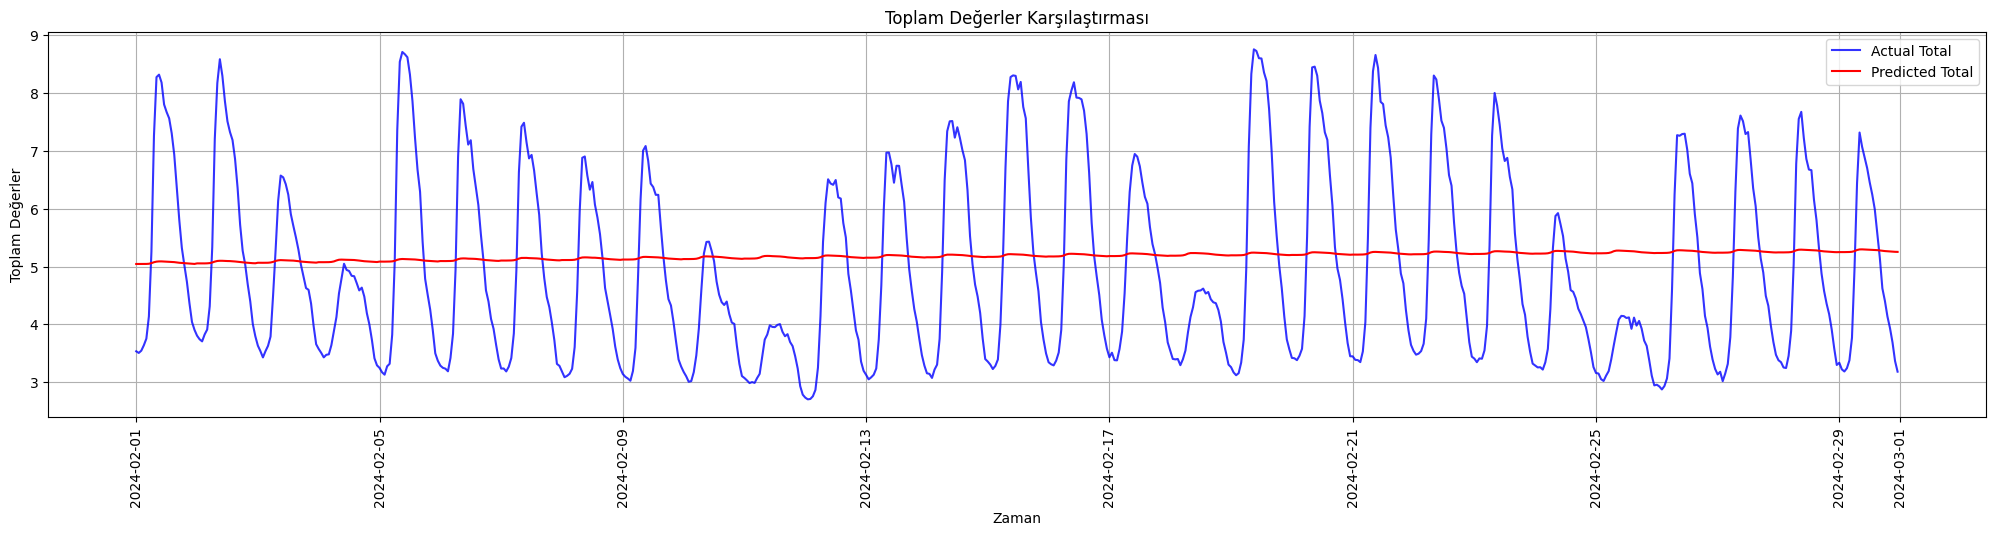

In [15]:
df_feb = df_feb[common_columns]## common columns were chosen at the beggining with .intersection



df_feb_sum = df_feb.sum(axis=1)
all_pred_sum = allPred.sum(axis=1)

import matplotlib.pyplot as plt




# Ortak indeks kısmını kullanarak grafik oluşturalım
plt.figure(figsize=(25, 5))
plt.plot(df_feb_sum.index, df_feb_sum.values, label='Actual Total', color='blue', alpha=0.8)  # Gerçek veri toplamları
plt.plot(all_pred_sum.index, all_pred_sum.values, label='Predicted Total', color='red')  # Tahmin edilen veri toplamları

plt.title('Toplam Değerler Karşılaştırması')
plt.xlabel('Zaman')
plt.xticks(rotation=90)
plt.ylabel('Toplam Değerler')
plt.legend()
plt.grid(True)
plt.show()

In [16]:
def create_pivot_table_for_checking_estimated(dataframe):
    pivot_table = dataframe.pivot_table(
        values='IMPORTESTIMATED',  
        index='POINTSERNO',     
        columns='PROFILEDATE',    
        aggfunc='sum',
        fill_value=np.nan           
    )

    rows_to_keep = pivot_table.sum(axis=1) != 0

    # Apply the filter to the pivot_table to drop rows with a sum of 0
    filtered_table = pivot_table[rows_to_keep]
    filtered_table.columns = pd.to_datetime(filtered_table.columns)
    selected_dates = filtered_table.loc[:, '2024-02-01':'2024-02-29']
    selected_dates = selected_dates.dropna(how='any')
    
    if (selected_dates.isna().sum().sum()) == 0:
        print('There is no nan values and we can continue to the next step')
    else:
        print('There are nan values in the dataset, please check the data')
    return(selected_dates)

df_pivoted_for_checking_e = create_pivot_table_for_checking_estimated(tic_ag_e)
df_pivoted_for_checking_e = df_pivoted_for_checking_e.transpose()#.reset_index(drop = True)
math = df_pivoted_for_checking_e[common_columns]


There is no nan values and we can continue to the next step


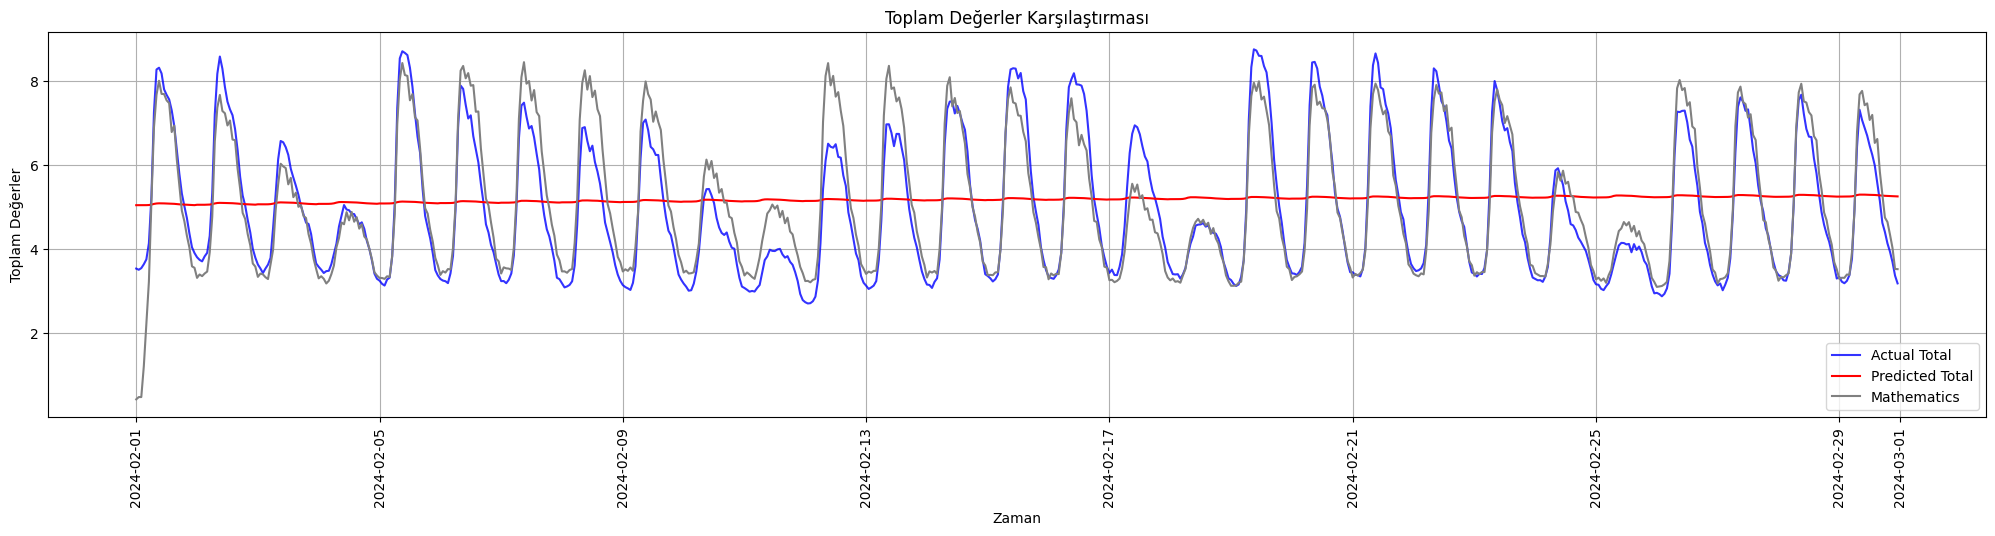

In [17]:


math_sum =math.sum(axis=1)

# Ortak indeks kısmını kullanarak grafik oluşturalım
plt.figure(figsize=(25, 5))
plt.plot(df_feb_sum.index, df_feb_sum.values, label='Actual Total', color='blue', alpha=0.8)  # Gerçek veri toplamları
plt.plot(all_pred_sum.index, all_pred_sum.values, label='Predicted Total', color='red')  # Tahmin edilen veri toplamları
plt.plot(math_sum.index, math_sum.values, label='Mathematics', color='grey') # matematik yöntem 

plt.title('Toplam Değerler Karşılaştırması')
plt.xlabel('Zaman')
plt.xticks(rotation=90)
plt.ylabel('Toplam Değerler')
plt.legend()
plt.grid(True)
plt.show()

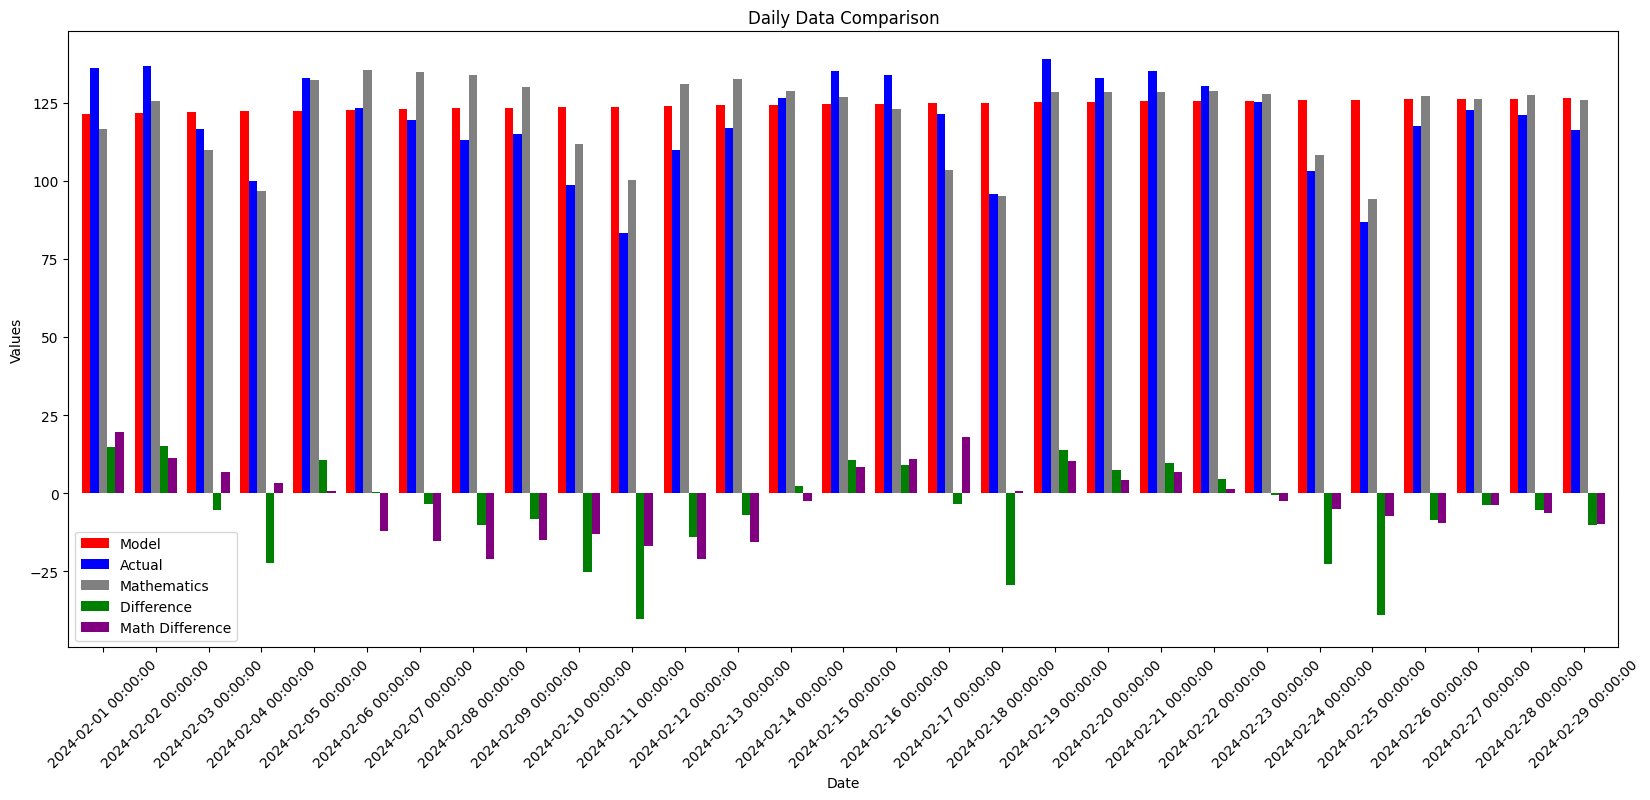

In [18]:
sums_0_24 = all_pred_sum.copy()
sum_1_24 = df_feb_sum.copy()
sum_2_24 = math_sum.copy()



sums_0_24.index = pd.to_datetime(sums_0_24.index)#predict
sum_1_24.index = pd.to_datetime(sum_1_24.index)#uzlaşma 
sum_2_24.index = pd.to_datetime(sum_2_24.index)#matematik
 
diff_ac_pc = sum_1_24 - sums_0_24
diff_ac_ec = sum_1_24 - sum_2_24
 
daily_sums_0_24 = sums_0_24.resample('D').sum()
daily_sums_1_24 = sum_1_24.resample('D').sum()
daily_sums_2_24 = sum_2_24.resample('D').sum()
daily_diff_ac_pc = diff_ac_pc.resample('D').sum()
daily_diff_ac_ec = diff_ac_ec.resample('D').sum()
 
data = pd.DataFrame({
    'Model': daily_sums_0_24,
    'Actual': daily_sums_1_24,
    'Mathematics': daily_sums_2_24,
    'Difference ': daily_diff_ac_pc,
    'Math Difference': daily_diff_ac_ec
})
 
colors = ['red', 'blue','grey',  'green', 'purple']  
 
# Plotting
fig, ax = plt.subplots(figsize=(20, 8))
data.plot(kind='bar', ax=ax, width=0.8, color=colors)
ax.set_xlabel('Date')
ax.set_ylabel('Values')
ax.set_title('Daily Data Comparison')
plt.xticks(rotation=45)
plt.show()